In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import matplotlib.colors as mcolors

In [2]:
m = folium.Map([33.447046773463654, -112.08091337731709], zoom_start=5)

In [3]:
df = pd.read_csv('./../../CSVs/RAW/battery-manufacturing.csv')
df[['lon', 'lat']] = df['WKT'].str.extract(r'POINT \(([^ ]+) ([^)]+)\)').astype(float)
df

,WKT,name,description,lon,lat
0,POINT (-117.5343363 33.8795296),"US Battery Manufacturing Co,",NaN,-117.534336,33.879530
1,POINT (-90.44327229999999 38.7161681),"Electro Battery Manufacturing Co,",NaN,-90.443272,38.716168
2,POINT (-86.9193055 38.9043626),"Battery Innovation Center, Inc.,",NaN,-86.919305,38.904363
3,POINT (-85.8845077 37.5883111),"BlueOvalSK Battery Park,",NaN,-85.884508,37.588311
4,POINT (-84.9891901 37.0669259),"Superior Battery Manufacturing Company, Inc.,",NaN,-84.989190,37.066926
5,POINT (-82.123291 33.54465479999999),"US Battery Mfg Co,",NaN,-82.123291,33.544655
6,POINT (-82.0072474 33.37056),"US Battery Manufacturing Co,",NaN,-82.007247,33.370560
7,POINT (-79.6403983 35.8924702),"Toyota Battery Manufacturing,",NaN,-79.640398,35.892470
8,POINT (-84.259261 39.5690389),"American Battery Solutions, Inc.,",NaN,-84.259261,39.569039
9,POINT (-122.6178412 45.3981271),"Battery Factory,",NaN,-122.617841,45.398127


In [4]:
rad_lat = np.radians(df['lat'])
rad_lon = np.radians(df['lon'])

df['x'] = np.cos(rad_lat) * np.cos(rad_lon)
df['y'] = np.cos(rad_lat) * np.sin(rad_lon)
df['z'] = np.sin(rad_lat)

In [5]:
X = df[['x', 'y', 'z']]

In [6]:
k_values = range(2, 8)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

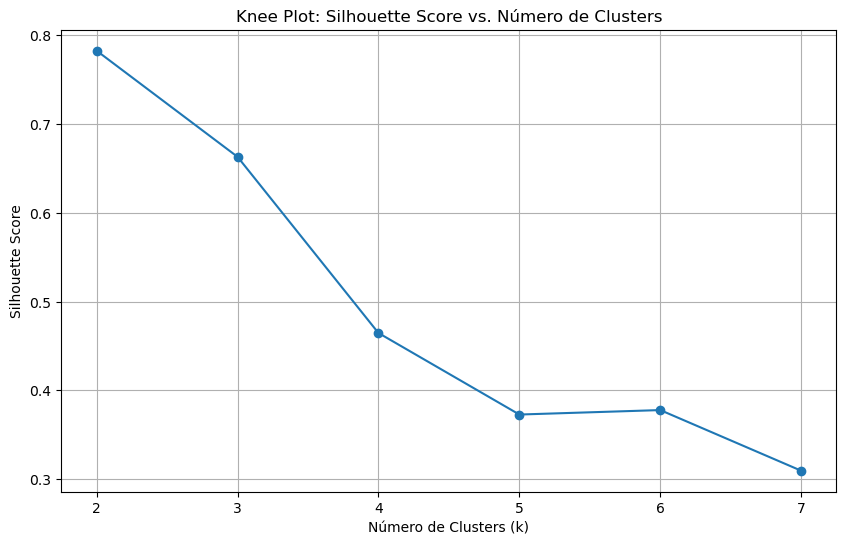

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Knee Plot: Silhouette Score vs. Número de Clusters')
plt.grid(True)
plt.show()

In [8]:
k=4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)
sil_score = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.4645


In [9]:
df['cluster'] = cluster_labels
df

,WKT,name,description,lon,lat,x,y,z,cluster
0,POINT (-117.5343363 33.8795296),"US Battery Manufacturing Co,",NaN,-117.534336,33.879530,-0.383790,-0.736177,0.557449,2
1,POINT (-90.44327229999999 38.7161681),"Electro Battery Manufacturing Co,",NaN,-90.443272,38.716168,-0.006036,-0.780231,0.625463,0
2,POINT (-86.9193055 38.9043626),"Battery Innovation Center, Inc.,",NaN,-86.919305,38.904363,0.041822,-0.777071,0.628022,0
3,POINT (-85.8845077 37.5883111),"BlueOvalSK Battery Park,",NaN,-85.884508,37.588311,0.056869,-0.790371,0.609984,0
4,POINT (-84.9891901 37.0669259),"Superior Battery Manufacturing Company, Inc.,",NaN,-84.989190,37.066926,0.069694,-0.794882,0.602747,0
5,POINT (-82.123291 33.54465479999999),"US Battery Mfg Co,",NaN,-82.123291,33.544655,0.114218,-0.825592,0.552587,3
6,POINT (-82.0072474 33.37056),"US Battery Manufacturing Co,",NaN,-82.007247,33.370560,0.116123,-0.827018,0.550052,3
7,POINT (-79.6403983 35.8924702),"Toyota Battery Manufacturing,",NaN,-79.640398,35.892470,0.145680,-0.796913,0.586266,3
8,POINT (-84.259261 39.5690389),"American Battery Solutions, Inc.,",NaN,-84.259261,39.569039,0.077107,-0.766991,0.637008,0
9,POINT (-122.6178412 45.3981271),"Battery Factory,",NaN,-122.617841,45.398127,-0.378496,-0.591432,0.712003,1


In [10]:
centroids = kmeans.cluster_centers_

centroids_lat = np.degrees(np.arcsin(centroids[:, 2]))
centroids_lon = np.degrees(np.arctan2(centroids[:, 1], centroids[:, 0]))

centroids_df = pd.DataFrame({'cluster': range(k), 'lat': centroids_lat, 'lon': centroids_lon})

print(centroids_df)

   cluster        lat         lon
0        0  38.363232  -86.495066
1        1  45.398127 -122.617841
2        2  33.879530 -117.534336
3        3  34.261312  -81.272761


In [11]:
unique_clusters = np.unique(cluster_labels)

colors = [plt.cm.viridis(i / (len(unique_clusters) - 1)) for i in range(len(unique_clusters))]

cluster_colors = {cluster: mcolors.to_hex(colors[i]) for i, cluster in enumerate(unique_clusters)}

df['color'] = df['cluster'].map(cluster_colors)

In [12]:
def mark_on_map(row):
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.7,
        popup=f"Cluster: {row['cluster']}"
    ).add_to(m)

df.apply(mark_on_map, axis=1)

m

In [13]:
def mark_centroids(row):
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"Centroid Cluster {row['cluster']}",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

centroids_df.apply(mark_centroids, axis=1)
m

In [14]:
df.to_csv('./../../CSVs/Geographical/GEOGRAPHICAL Battery_manufacturing.csv', index=False)